### API Connection

In [3]:
from onboard.client import OnboardClient
from key import api_key

client = OnboardClient(api_key=api_key)

## Select Sensor Types and Get Metadata

In [4]:
# Select point types
zone_sensors = ['Chilled Water Supply Flow', 'Outside Air Temperature']

In [5]:
import pandas as pd
from onboard.client.models import PointSelector

# buildings in the portfolio
building_df = pd.json_normalize(client.get_all_buildings())

# generate a query for point types
query = PointSelector()
query.point_types = zone_sensors
selection = client.select_points(query)

# point data
sensor_metadata = client.get_points_by_ids(selection['points'])
sensor_metadata_df = pd.DataFrame(sensor_metadata)

# equipment data
equip_metadata = client.get_equipment_by_ids(selection['equipment'])
equip_metadata_df = pd.DataFrame(equip_metadata)

# join sensor and equip and building meta
df = pd.merge(
    sensor_metadata_df,
    equip_metadata_df.drop(
        columns=['building_id']).rename(
        columns={"id": "equip_id", "equip_id": "equip_name"}),
    left_on='equip_id', right_on='equip_id', how='left').merge(
    building_df[['id', 'name', 'address']].rename(
        columns={"id": "building_id", "name": "building_name"}),
    left_on='building_id', right_on='building_id', how='left'
)

# filter out missing data
df = df[~(df['last_updated'].isna())]

df.shape

(1692, 40)

## Choose a Building to Analyze

In [6]:
df.groupby(['building_name', 'type']).count()['id'].head()

building_name  type                     
102854         Outside Air Temperature      1
104078         Outside Air Temperature      1
104698         Chilled Water Supply Flow    2
               Outside Air Temperature      8
108223         Outside Air Temperature      1
Name: id, dtype: int64

In [7]:
# select a building
bldg = 'BBH'

display_cols = ['id','building_name','equip_name', 'name', 'type',]
bldg_df = df[df['building_name'] == bldg][display_cols + ['value', 'units']]

# id selector, choose the flow sensor with the highest reading
bldg_df.value = bldg_df.value.astype(float)
sample_ids = pd.DataFrame(bldg_df.groupby('type').max()).id.to_list()

bldg_df[bldg_df.id.isin(sample_ids)]

,id,building_name,equip_name,name,type,value,units
461,443629,BBH,meter-CHW Flow,chw_gpm_avg_2,Chilled Water Supply Flow,1.00,usGallonsPerMinute
938,444798,BBH,Site-Sensor,building_oat_9,Outside Air Temperature,37.09,degreesFahrenheit


In [8]:
bldg_df

,id,building_name,equip_name,name,type,value,units
459,443568,BBH,Site-Sensor,building_oat_11,Outside Air Temperature,37.09,degreesFahrenheit
460,443618,BBH,chilledWaterPlant-CHWS,chw_gpm_1,Chilled Water Supply Flow,4.01,milliamperes
461,443629,BBH,meter-CHW Flow,chw_gpm_avg_2,Chilled Water Supply Flow,1.00,usGallonsPerMinute
462,443681,BBH,hotWaterPlant-HWPS,oa_temp_1,Outside Air Temperature,32.79,degreesFahrenheit
463,443684,BBH,Site-Sensor,oa_temp_5,Outside Air Temperature,34.59,degreesFahrenheit
464,444239,BBH,Site-Sensor,building_oat_1,Outside Air Temperature,37.09,degreesFahrenheit
938,444798,BBH,Site-Sensor,building_oat_9,Outside Air Temperature,37.09,degreesFahrenheit


## Query Telemetry Data

In [6]:
from onboard.client.models import TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries

# look at data from the last week of July / beginning of August"
start_stamp = "2022-07-18T00:00:00Z"
end_stamp = "2022-08-7T00:00:00Z"

# query the server
timeseries_query = TimeseriesQuery(point_ids=sample_ids, start=start_stamp , end=end_stamp)
sensor_data = points_df_from_streaming_timeseries(client.stream_point_timeseries(timeseries_query))

In [7]:
# clean the data
sensor_data.index = pd.to_datetime(sensor_data.timestamp)
sensor_data.index.name = 'time'
five_min_data = sensor_data.resample('5T').mean() # resample to consistent 5-min interval
five_min_data = five_min_data.interpolate(limit=12)  # allow up to 1-hour of interpolation

<AxesSubplot:xlabel='time'>

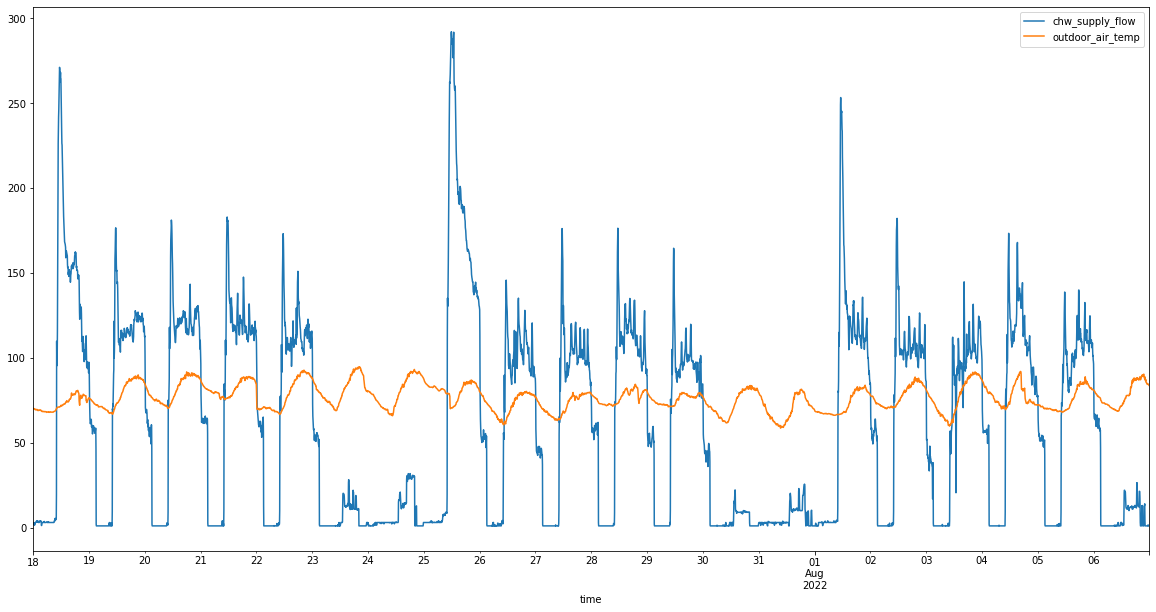

In [8]:
five_min_data = five_min_data.rename(columns={443629: "chw_supply_flow", 444798: "outdoor_air_temp"}) 
five_min_data.plot(figsize=(20, 10))

## What's Driving CHW Consumption ?

### Time-Based Features

In [9]:
def get_workweek(df):
    if df['weekday'] in [0, 1, 2, 3, 4]:
        return 'week'
    else:
        return 'weekend'

In [10]:
# day type feature coding
five_min_data['hour'] = five_min_data.index.hour
five_min_data['weekday'] = five_min_data.index.weekday
five_min_data['workweek'] = five_min_data.apply(get_workweek, axis=1)

<AxesSubplot:title={'center':'CHW Flow per Hour'}, xlabel='hour', ylabel='CHW Supply Flow'>

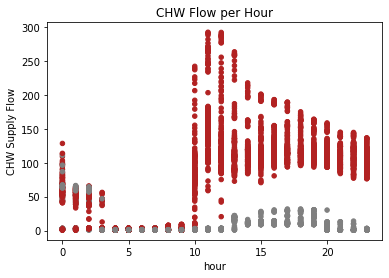

In [11]:
# plot flow per hour, color by weekday vs weekend
cmap = {'week': 'firebrick', 'weekend': 'gray'}

five_min_data.plot(x='hour', 
                   y='chw_supply_flow',
                   ylabel='CHW Supply Flow',
                   kind='scatter',
                   title='CHW Flow per Hour',
                   c=[cmap.get(c, 'black') for c in five_min_data.workweek])

In [12]:
def get_opp_status(df):
    
    if (df['workweek'] == 'week') & ((df['hour'] >= 10) | (df['hour'] == 0)):
        return 1
    else:
        return 0
    
five_min_data['operation'] = five_min_data.apply(get_opp_status, axis=1)

### Temperature Based

<AxesSubplot:title={'center':'Temp Correlation and Operation'}, xlabel='Temperature', ylabel='CHW Supply Flow'>

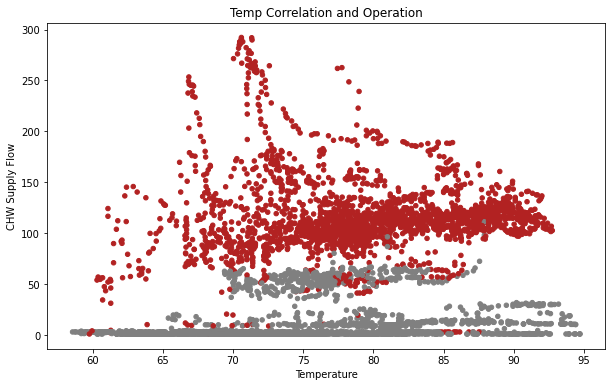

In [13]:
import matplotlib.pyplot as plt

# plot CHW Flow per Deg F.
cmap = {1: 'firebrick', 0: 'gray'}
five_min_data.plot(x='outdoor_air_temp', xlabel='Temperature',
                   y='chw_supply_flow', ylabel='CHW Supply Flow',
                   kind='scatter',
                   title = 'Temp Correlation and Operation',
                   c=[cmap.get(c, 'black') for c in five_min_data.operation],
                   figsize=(10, 6))

### Stats Based Feature Selection

In [14]:
five_min_data[['operation', 'chw_supply_flow']].corr()

,operation,chw_supply_flow
operation,1.000000,0.866544
chw_supply_flow,0.866544,1.000000


In [15]:
five_min_data[['outdoor_air_temp', 'chw_supply_flow']].corr()

,outdoor_air_temp,chw_supply_flow
outdoor_air_temp,1.000000,0.337473
chw_supply_flow,0.337473,1.000000


# Forecasting

### Back forecasting for Outlier Detection

In [16]:
# prepare data for forecasting
df_prophet = five_min_data[['chw_supply_flow', 'operation']].copy()
df_prophet = df_prophet.rename(columns={"chw_supply_flow": "y"})  # CHW Flow 
df_prophet['ds'] = df_prophet.index
df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)

In [17]:
from prophet import Prophet

# create a model
m = Prophet(changepoint_prior_scale=0.005)
m.add_regressor('operation', mode='multiplicative')
m = m.fit(df_prophet)

forecast = m.predict(df_prophet)
forecast['fact'] = df_prophet['y'].reset_index(drop = True)

Importing plotly failed. Interactive plots will not work.
12:26:16 - cmdstanpy - INFO - Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# function to code anomailes from result

def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['yhat_upper'] < 1, 'yhat_upper'] = 1
    forecasted.loc[forecasted['yhat_lower'] < 0, 'yhat_lower'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1

    # anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] == 1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper']) / forecast['fact']
    forecasted.loc[forecasted['yhat_upper'] < 10, 'importance'] = .01
                       
    return forecasted

pred = detect_anomalies(forecast)

In [19]:
import altair as alt

def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']).interactive().properties(title='Anomaly Detection')

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='CHW FLow'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Outliers'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size('importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred.iloc[:5000,])

alt.LayerChart(...)

### Predict Future Consumption
#### Could be used to avoid demand charges

In [20]:
test_days = 3
test_period = test_days * 288 # 5-min intervals per hour * hours in a day

# every thing except the last week
df_train = df_prophet.iloc[:(len(df_prophet.index) - test_period)]
# the last week
df_test = df_prophet.iloc[-test_period:]

In [21]:
# create a model
m_future = Prophet(changepoint_prior_scale=0.005,  growth='flat')
m_future.add_regressor('operation', mode='multiplicative')

# train
m_future = m_future.fit(df_train)

# predict
future = m_future.predict(df_test)

12:26:20 - cmdstanpy - INFO - Chain [1] start processing
12:26:20 - cmdstanpy - INFO - Chain [1] done processing


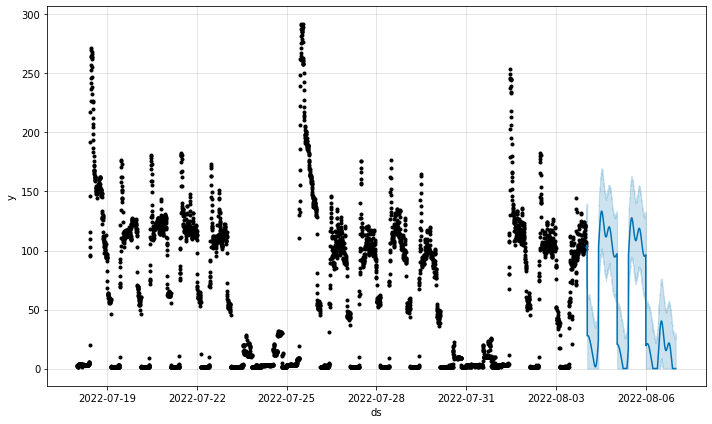

In [22]:
# postprocess results
future.loc[future['yhat_upper'] < 1, 'yhat_upper'] = 1
future.loc[future['yhat'] < 0, 'yhat'] = 0
future.loc[future['yhat_lower'] < 0, 'yhat_lower'] = 0

fig = m_future.plot(future)

R-squared = 0.84


<AxesSubplot:xlabel='ds'>

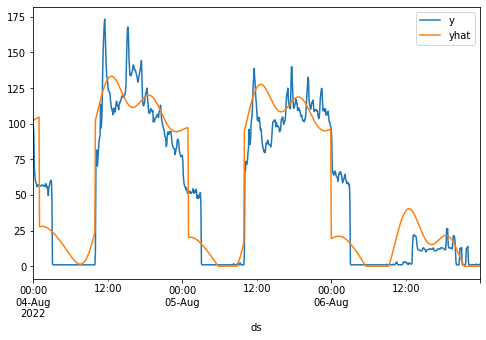

In [23]:
from sklearn.metrics import r2_score

# forecast accuracy
future.index = future.ds
future['y'] = df_test['y'].values

print(f'R-squared = {round(r2_score(future["y"], future["yhat"]), 2)}')

future[['y', 'yhat']].plot(figsize=(8,5))